In [241]:
import numpy as np
import requests
import pandas as pd
import geopandas as gpd
import rasterio
from rasterstats import zonal_stats
import rasterio.mask
import matplotlib.pyplot as plt
import fiona
import rasterio
import rasterio.mask
from rasterio.enums import Resampling
import json

In [2]:
# get list of c4f cities
boundary_georef = pd.read_csv('https://cities-cities4forests.s3.eu-west-3.amazonaws.com/data/boundaries/v_0/boundary_georef.csv')
boundary_georef

,city_name,geo_name,aoi_boundary_name,units_boundary_name,city_boundary_name,country_code,geo_level
0,Salvador,BRA-Salvador,ADM4union,ADM4,BRA-Salvador-ADM4,BRA,ADM4
1,Bukavu,COD-Bukavu,ADM3union,ADM3,COD-Bukavu-ADM3,COD,ADM3
2,Uvira,COD-Uvira,ADM3union,ADM3,COD-Uvira-ADM3,COD,ADM3
3,Brazzaville,COG-Brazzaville,ADM4union,ADM4,COG-Brazzaville-ADM4,COG,ADM4
4,Barranquilla,COL-Barranquilla,ADM4union,ADM4,COL-Barranquilla-ADM4,COL,ADM4
5,Addis_Ababa,ETH-Addis_Ababa,ADM4union,ADM4,ETH-Addis_Ababa-ADM4,ETH,ADM4
6,Dire_Dawa,ETH-Dire_Dawa,ADM3union,ADM3,ETH-Dire_Dawa-ADM3,ETH,ADM3
7,Nairobi,KEN-Nairobi,ADM3union,ADM3,KEN-Nairobi-ADM3,KEN,ADM3
8,Antananarivo,MDG-Antananarivo,ADM4union,ADM4,MDG-Antananarivo-ADM4,MDG,ADM4
9,Mexico_City,MEX-Mexico_City,ADM2union,ADM2,MEX-Mexico_City-ADM2,MEX,ADM2


In [42]:
tml_not_available_cities = ['BRA-Salvador','MEX-Monterrey']
boundary_georef = boundary_georef[~boundary_georef['geo_name'].isin(tml_not_available_cities)].reset_index(drop=True)
boundary_georef

,city_name,geo_name,aoi_boundary_name,units_boundary_name,city_boundary_name,country_code,geo_level
0,Bukavu,COD-Bukavu,ADM3union,ADM3,COD-Bukavu-ADM3,COD,ADM3
1,Uvira,COD-Uvira,ADM3union,ADM3,COD-Uvira-ADM3,COD,ADM3
2,Brazzaville,COG-Brazzaville,ADM4union,ADM4,COG-Brazzaville-ADM4,COG,ADM4
3,Barranquilla,COL-Barranquilla,ADM4union,ADM4,COL-Barranquilla-ADM4,COL,ADM4
4,Addis_Ababa,ETH-Addis_Ababa,ADM4union,ADM4,ETH-Addis_Ababa-ADM4,ETH,ADM4
5,Dire_Dawa,ETH-Dire_Dawa,ADM3union,ADM3,ETH-Dire_Dawa-ADM3,ETH,ADM3
6,Nairobi,KEN-Nairobi,ADM3union,ADM3,KEN-Nairobi-ADM3,KEN,ADM3
7,Antananarivo,MDG-Antananarivo,ADM4union,ADM4,MDG-Antananarivo-ADM4,MDG,ADM4
8,Mexico_City,MEX-Mexico_City,ADM2union,ADM2,MEX-Mexico_City-ADM2,MEX,ADM2
9,Musanze,RWA-Musanze,ADM5union,ADM5,RWA-Musanze-ADM5,RWA,ADM5


In [389]:
i = 2
city_name = boundary_georef.loc[i, 'geo_name']+'-'+boundary_georef.loc[i, 'aoi_boundary_name']
print(city_name)

boundary_id_aoi = boundary_georef.loc[i, 'geo_name']+'-'+boundary_georef.loc[i, 'aoi_boundary_name']
boundary_id_unit = boundary_georef.loc[i, 'geo_name']+'-'+boundary_georef.loc[i, 'units_boundary_name']
print(boundary_id_aoi)

COG-Brazzaville-ADM4union
COG-Brazzaville-ADM4union


# AOI level

In [336]:
# load boundary
# with fiona.open("https://cities-cities4forests.s3.eu-west-3.amazonaws.com/data/boundaries/v_0/boundary-" +city_name+".geojson", "r") as shapefile:
#     shapes = [feature["geometry"] for feature in shapefile]
    
boundary_geo = gpd.read_file("https://cities-cities4forests.s3.eu-west-3.amazonaws.com/data/boundaries/v_0/boundary-" +boundary_id_aoi+".geojson")
shapes = boundary_geo["geometry"][0]

In [337]:
# load esa world cover
with rasterio.open("https://cities-cities4forests.s3.eu-west-3.amazonaws.com/data/land_use/esa_world_cover/v_0/" +boundary_id_aoi+"-ESA-world_cover-2020-built_up.tif") as src:
    out_image_lc, out_transform_lc = rasterio.mask.mask(src, shapes, crop=True, nodata=0)
    out_meta_lc = src.meta

# keep built-up areas
out_image_lc[out_image_lc != 50] = 0
out_image_lc[out_image_lc == 50] = 1

out_meta_lc

C:\Users\Saif.Shabou\anaconda3\envs\urbanshift_env\lib\site-packages\rasterio\features.py:445: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  all_bounds = [bounds(shape, transform=~dataset.transform) for shape in shapes]
C:\Users\Saif.Shabou\anaconda3\envs\urbanshift_env\lib\site-packages\rasterio\features.py:288: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for index, item in enumerate(shapes):


{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': None,
 'width': 1961,
 'height': 3332,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(8.983152841195215e-05, 0.0, 15.144891925005368,
        0.0, -8.983152841195215e-05, -4.076040683725779)}

In [338]:
# Tree cover
with rasterio.open("https://cities-cities4forests.s3.eu-west-3.amazonaws.com/data/tree_cover/tree_mosaic_land/v_0/" +boundary_id_aoi+"-TML-tree_cover-2000.tif") as src:
    out_image_tml, out_transform_tml = rasterio.mask.mask(src, shapes, crop=True, nodata=0)
    out_meta_tml = src.meta
    
out_meta_tml

C:\Users\Saif.Shabou\anaconda3\envs\urbanshift_env\lib\site-packages\rasterio\features.py:445: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  all_bounds = [bounds(shape, transform=~dataset.transform) for shape in shapes]
C:\Users\Saif.Shabou\anaconda3\envs\urbanshift_env\lib\site-packages\rasterio\features.py:288: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for index, item in enumerate(shapes):


{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': None,
 'width': 1961,
 'height': 3332,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(8.983152841195215e-05, 0.0, 15.144877038027836,
        0.0, -8.983152841195215e-05, -4.076015770163917)}

In [339]:
# load and esample tree cover
upscale_factor_width =  out_meta_lc['width']/out_meta_tml['width']
upscale_factor_height =  out_meta_lc['height']/out_meta_tml['height']

with rasterio.open("https://cities-cities4forests.s3.eu-west-3.amazonaws.com/data/tree_cover/tree_mosaic_land/v_0/" +boundary_id_aoi+"-TML-tree_cover-2000.tif") as dataset:

    # resample data to target shape
    tml_sampled = dataset.read(
        out_shape=(
            dataset.count,
            int(dataset.height * upscale_factor_height),
            int(dataset.width * upscale_factor_width)
        ),
        resampling=Resampling.bilinear
    )

    # scale image transform
    transform = dataset.transform * dataset.transform.scale(
        (dataset.width / data.shape[-1]),
        (dataset.height / data.shape[-2])
    )

In [340]:
# compute tree cover in built up
city_built_tml = out_image_lc * tml_sampled
np.nanmean(city_built_tml,dtype=np.float64)

0.889839906403176

# Unit of Analysis

In [430]:
# load boundary
# with fiona.open("https://cities-cities4forests.s3.eu-west-3.amazonaws.com/data/boundaries/v_0/boundary-" +city_name+".geojson", "r") as shapefile:
#     shapes = [feature["geometry"] for feature in shapefile]
    
boundary_geo = gpd.read_file("https://cities-cities4forests.s3.eu-west-3.amazonaws.com/data/boundaries/v_0/boundary-" +boundary_id_unit+".geojson")
shapes = boundary_geo["geometry"][0]

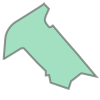

In [431]:
shapes

In [432]:
# load esa world cover
with rasterio.open("https://cities-cities4forests.s3.eu-west-3.amazonaws.com/data/land_use/esa_world_cover/v_0/" +boundary_id_aoi+"-ESA-world_cover-2020-built_up.tif") as src:
    out_image_lc, out_transform_lc = rasterio.mask.mask(src, shapes, crop=True, nodata=0)
    out_meta_lc = src.meta

# keep built-up areas
out_image_lc[out_image_lc != 50] = 0
out_image_lc[out_image_lc == 50] = 1

C:\Users\Saif.Shabou\anaconda3\envs\urbanshift_env\lib\site-packages\rasterio\features.py:445: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  all_bounds = [bounds(shape, transform=~dataset.transform) for shape in shapes]
C:\Users\Saif.Shabou\anaconda3\envs\urbanshift_env\lib\site-packages\rasterio\features.py:288: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for index, item in enumerate(shapes):


In [433]:
out_meta_lc.update({"driver": "GTiff",
                 "height": out_image_lc.shape[1],
                 "width": out_image_lc.shape[2],
                 "transform": out_transform_lc})
out_meta_lc

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': None,
 'width': 491,
 'height': 452,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(8.983152841195215e-05, 0.0, 15.253767737440654,
        0.0, -8.983152841195215e-05, -4.151409336063407)}

In [434]:
# Tree cover
with rasterio.open("https://cities-cities4forests.s3.eu-west-3.amazonaws.com/data/tree_cover/tree_mosaic_land/v_0/" +boundary_id_aoi+"-TML-tree_cover-2000.tif") as src:
    out_image_tml, out_transform_tml = rasterio.mask.mask(src, shapes, crop=True, nodata=0)
    out_meta_tml = src.meta
    
    

C:\Users\Saif.Shabou\anaconda3\envs\urbanshift_env\lib\site-packages\rasterio\features.py:445: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  all_bounds = [bounds(shape, transform=~dataset.transform) for shape in shapes]
C:\Users\Saif.Shabou\anaconda3\envs\urbanshift_env\lib\site-packages\rasterio\features.py:288: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for index, item in enumerate(shapes):


In [435]:
with rasterio.open("./data/tml_masked.tif", "w", **out_meta_tml) as dest:
    dest.write(out_image_tml)

In [436]:
out_meta_tml.update({"driver": "GTiff",
                 "height": out_image_tml.shape[1],
                 "width": out_image_tml.shape[2],
                 "transform": out_transform_tml})
out_meta_tml

{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': None,
 'width': 491,
 'height': 451,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(8.983152841195215e-05, 0.0, 15.253752850463123,
        0.0, -8.983152841195215e-05, -4.1514742540299565)}

In [437]:
# load and esample tree cover
upscale_factor_width =  out_meta_lc['width']/out_meta_tml['width']
print(upscale_factor_width)
upscale_factor_height =  out_meta_lc['height']/out_meta_tml['height']
print(upscale_factor_height)

1.0
1.0022172949002217


In [438]:
# load and esample tree cover
with rasterio.open("./data/tml_masked.tif") as dataset:

    # resample data to target shape
    
    tml_sampled = dataset.read(
        
        out_shape=(
            dataset.count,
            int(dataset.height * upscale_factor_height),
            int(dataset.width * upscale_factor_width)
        ),
        
        resampling=Resampling.bilinear
    )
    
    

    # scale image transform
    transform = dataset.transform * dataset.transform.scale(
        (dataset.width / data.shape[-1]),
        (dataset.height / data.shape[-2])
    )

In [439]:
# compute tree cover in built up
city_built_tml = out_image_lc * tml_sampled
# np.nanmean(city_built_tml,dtype=np.float64)

ValueError: operands could not be broadcast together with shapes (1,452,491) (1,3339,1961) 

In [440]:
test_1 = tml_sampled[tml_sampled!= float('inf')]
test_1 = test_1[test_1!= float('-inf')]
np.nanmean(test_1,dtype=np.float64)

9.510003694071153e+30

In [64]:
city_name = "COG-Brazzaville-ADM4union"

In [65]:
# load boundary
city_boundary_path = "https://cities-cities4forests.s3.eu-west-3.amazonaws.com/data/boundaries/v_0/boundary-" +city_name+".geojson"
city_boundary = gpd.read_file(city_boundary_path)

In [66]:
# load boundary
with fiona.open("https://cities-cities4forests.s3.eu-west-3.amazonaws.com/data/boundaries/v_0/boundary-" +city_name+".geojson", "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]

In [67]:
# ESA built up
city_name = "COG-Brazzaville-ADM4union"
city_lc_built = "https://cities-cities4forests.s3.eu-west-3.amazonaws.com/data/land_use/esa_world_cover/v_0/" +city_name+"-ESA-world_cover-2020-built_up.tif"

city_lc_built = rasterio.open(city_lc_built)
city_lc_built_data = city_lc_built.read(1)
print(city_lc_built_data)

[[ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ... 50 50  0]
 [ 0  0  0 ... 50 50  0]
 [ 0  0  0 ... 50 50 50]]


In [68]:
with rasterio.open("https://cities-cities4forests.s3.eu-west-3.amazonaws.com/data/land_use/esa_world_cover/v_0/" +city_name+"-ESA-world_cover-2020-built_up.tif") as src:
    out_image_lc, out_transform_lc = rasterio.mask.mask(src, shapes, crop=True)
    out_meta_lc = src.meta

out_image_lc[out_image_lc != 50] = 0
out_image_lc[out_image_lc == 50] = 1


In [5]:
city_lc_built_data[city_lc_built_data == 50] = 1
city_lc_built_data

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 1, 1, 1]], dtype=uint8)

In [69]:
# Tree cover
city_name = "COG-Brazzaville-ADM4union"
city_tml_path= "https://cities-cities4forests.s3.eu-west-3.amazonaws.com/data/tree_cover/tree_mosaic_land/v_0/" +city_name+"-TML-tree_cover-2000.tif"

city_tml = rasterio.open(city_tml_path)
city_tml_data = city_tml.read(1)
print(city_tml_data)

[[ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 ...
 [50. 80. 80. ...  0.  0.  0.]
 [30. 70. 80. ...  0.  0.  0.]
 [40. 50. 80. ...  0.  0.  0.]]


In [70]:
with rasterio.open("https://cities-cities4forests.s3.eu-west-3.amazonaws.com/data/tree_cover/tree_mosaic_land/v_0/" +city_name+"-TML-tree_cover-2000.tif") as src:
    out_image_tml, out_transform_tml = rasterio.mask.mask(src, shapes, crop=True)
    out_meta_tml = src.meta

In [71]:
out_image_tml

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

In [7]:
# tree cover in built up
city_built_tml = city_lc_built_data * city_tml_data
city_built_tml

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [72]:
city_built_tml_crop = out_image_lc * out_image_tml
np.nanmean(city_built_tml_crop,dtype=np.float64)

0.8490400565369274

In [19]:
np.nanmean(city_built_tml,dtype=np.float64)

1.308048389077753

In [11]:
# compute zonal stat
city_built_tml_stat = zonal_stats(city_boundary_path, 
                                  city_built_tml,
                                  stats= "mean",
                                 nodata=np.nan)

ValueError: Specify affine transform for numpy arrays

In [9]:
city_built_tml_stat

[{'mean': 17.800617211862633}]